<a href="https://colab.research.google.com/github/Chuuya1124/APM1105/blob/main/SA2_ANOVA_Awit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TWO-WAY ANOVA: EFFECT OF AD STATUS AND TREATMENT ON MEMORY

DESCRIPTIVE STATISTICS
--------------------------------------------------

AD_Status = 1
--------------------------------------------------
                     1       2       3       4
Valid            5.000   5.000   5.000   5.000
Mean            11.600  13.200  12.400  11.200
Std. Deviation   1.517   1.483   2.074   1.304
Skewness        -0.315  -0.552   0.236   0.541
SE Skewness      0.913   0.913   0.913   0.913
Kurtosis        -3.081   0.868  -1.963  -1.488
SE Kurtosis      2.000   2.000   2.000   2.000
Shapiro-Wilk     0.803   0.956   0.952   0.902
p-value          0.086   0.777   0.754   0.421

AD_Status = 2
--------------------------------------------------
                    1      2      3      4
Valid           5.000  5.000  5.000  5.000
Mean            8.600  7.600  8.200  6.600
Std. Deviation  0.894  1.949  0.837  2.074
Skewness        1.258 -0.081 -0.512 -0.236
SE Skewness     0.913  0.913  0.913  0.913
Kurtos

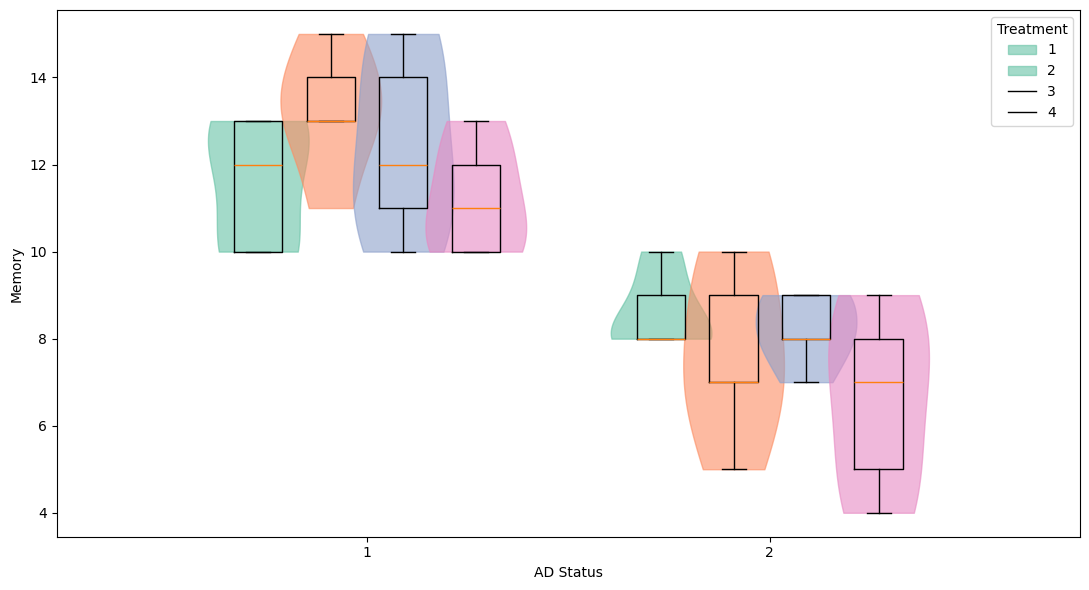


LEVENE'S TEST
--------------------------------------------------
F = 0.827, p = 0.572

TWO-WAY ANOVA (Type II)
------------------------------------------------------------------------------------------
                            sum_sq    df        F  PR(>F)
C(AD_Status)               189.225   1.0  75.3134  0.0000
C(Treatment)                14.475   3.0   1.9204  0.1461
C(AD_Status):C(Treatment)    8.675   3.0   1.1509  0.3436
Residual                    80.400  32.0      NaN     NaN

EFFECT SIZES (η²)
------------------------------------------------------------------------------------------
AD_Status η²   = 0.6463
Treatment η²   = 0.0494
Interaction η² = 0.0296

POST-HOC TEST (Tukey HSD)
------------------------------------------------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 1 - 1  1 - 2      1.6 0.7491 -1.6474  4.8474  F

In [ ]:
# =============================
# IMPORTS
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# =============================
# DATASET
# =============================
df = pd.read_csv("/content/drive/MyDrive/Awit/Alzheimers Mice Data.csv")

print("="*90)
print("TWO-WAY ANOVA: EFFECT OF AD STATUS AND TREATMENT ON MEMORY")
print("="*90, "\n")

# =============================
# DESCRIPTIVE STATISTICS
# =============================
print("DESCRIPTIVE STATISTICS")
print("-" * 50)

def calc_se_skew(n):
    return np.sqrt((6*n*(n-1)) / ((n-2)*(n+1)*(n+3)))

def calc_se_kurtosis(n):
    se_skew = calc_se_skew(n)
    return np.sqrt((4*(n**2 - 1) * se_skew**2) / ((n-3)*(n+5)))

for ad in df['AD_Status'].unique():
    print(f"\nAD_Status = {ad}")
    print("-" * 50)

    subset = df[df['AD_Status'] == ad]
    table_data = {}

    for trt, g in subset.groupby('Treatment'):
        y = g['Memory']
        n = len(y)
        w, p = shapiro(y)

        table_data[str(trt)] = {
            "Valid": n,
            "Mean": round(y.mean(), 3),
            "Std. Deviation": round(y.std(), 3),
            "Skewness": round(y.skew(), 3),
            "SE Skewness": round(calc_se_skew(n), 3),
            "Kurtosis": round(y.kurtosis(), 3),
            "SE Kurtosis": round(calc_se_kurtosis(n), 3),
            "Shapiro-Wilk": round(w, 3),
            "p-value": round(p, 3)
        }

    print(pd.DataFrame(table_data).to_string())

# =============================
# RAINCLOUD-STYLE PLOT
# =============================
print("\nCREATING RAINCLOUD PLOT")
print("-"*90)

plt.figure(figsize=(11, 6))

ad_levels = df['AD_Status'].unique()
treatments = df['Treatment'].unique()
colors = sns.color_palette("Set2", len(treatments))

positions = np.arange(len(ad_levels))
offset = 0.18

for i, trt in enumerate(treatments):
    shift = (i - (len(treatments)-1)/2) * offset
    x_pos = positions + shift

    data = [
        df[(df['AD_Status'] == ad) & (df['Treatment'] == trt)]['Memory']
        for ad in ad_levels
    ]

    violins = plt.violinplot(data, positions=x_pos, widths=0.25, showextrema=False)
    for body in violins['bodies']:
        body.set_color(colors[i])
        body.set_alpha(0.6)

    plt.boxplot(data, positions=x_pos, widths=0.12, showfliers=False)

plt.xticks(positions, ad_levels)
plt.xlabel("AD Status")
plt.ylabel("Memory")
plt.legend([str(t) for t in treatments], title="Treatment")
plt.tight_layout()
plt.show()

# =============================
# LEVENE'S TEST
# =============================
print("\nLEVENE'S TEST")
print("-"*50)

groups = df.groupby(['AD_Status', 'Treatment'])['Memory']
samples = [g for _, g in groups]

stat, p = levene(*samples)
print(f"F = {stat:.3f}, p = {p:.3f}")

# =============================
# TWO-WAY ANOVA (TYPE II)
# =============================
print("\nTWO-WAY ANOVA (Type II)")
print("-"*90)

model = ols(
    'Memory ~ C(AD_Status) + C(Treatment) + C(AD_Status):C(Treatment)',
    data=df
).fit()

anova2 = anova_lm(model, typ=2)
print(anova2.round(4))

# =============================
# ETA SQUARED
# =============================
print("\nEFFECT SIZES (η²)")
print("-"*90)

ss_total = anova2['sum_sq'].sum()

eta_ad = anova2.loc['C(AD_Status)', 'sum_sq'] / ss_total
eta_trt = anova2.loc['C(Treatment)', 'sum_sq'] / ss_total
eta_int = anova2.loc['C(AD_Status):C(Treatment)', 'sum_sq'] / ss_total

print(f"AD_Status η²   = {eta_ad:.4f}")
print(f"Treatment η²   = {eta_trt:.4f}")
print(f"Interaction η² = {eta_int:.4f}")

# =============================
# POST-HOC (TUKEY)
# =============================
print("\nPOST-HOC TEST (Tukey HSD)")
print("-"*90)

df['Group'] = (
    df['AD_Status'].astype(str) +
    " - " +
    df['Treatment'].astype(str)
)

tukey = pairwise_tukeyhsd(
    endog=df['Memory'],
    groups=df['Group'],
    alpha=0.05
)

print(tukey)

# =============================
# DESCRIPTIVES TABLE
# =============================
print("\nDESCRIPTIVES TABLE")
print("-"*90)

desc = df.groupby(['AD_Status', 'Treatment'])['Memory'].agg(
    N='count',
    Mean='mean',
    SD='std',
    SE='sem'
).reset_index()

desc['Coefficient of variation'] = desc['SD'] / desc['Mean']
print(desc.round(3).to_string(index=False))

# =============================
# TWO-WAY ANOVA (TYPE III)
# =============================
print("\nTWO-WAY ANOVA (Type III)")
print("-"*90)

anova3 = anova_lm(model, typ=3)
anova3['Mean Square'] = anova3['sum_sq'] / anova3['df']
anova3['Partial Eta Sq'] = (
    anova3['sum_sq'] /
    (anova3['sum_sq'] + anova3.loc['Residual', 'sum_sq'])
)

anova3 = anova3.rename(columns={
    'sum_sq': 'Sum of Squares',
    'PR(>F)': 'p'
})

print(anova3[['Sum of Squares', 'df', 'Mean Square', 'F', 'p', 'Partial Eta Sq']].round(4))
